In [1]:
import pandas as pd
import numpy as np
import time as time
import pickle
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
datadir = "data/meetups"
min_groupsize = 2
max_groupsize = 500
num_categories = 33
group_blacklist = set()

In [3]:
members = pd.read_csv(datadir+'/members.csv',delimiter = ',' , encoding = 'unicode_escape')

In [4]:
membersSF = members[members.city == "San Francisco"]

In [5]:
print(len(membersSF))

1493407


In [6]:
group_sizes = {}
for index, row in membersSF.iterrows():
    group_id = str(row["group_id"])
    if group_id in group_sizes:
        group_sizes[group_id] += 1
    else:
        group_sizes[group_id] = 1

In [7]:
for group in group_sizes:
    if group_sizes[group]>max_groupsize or group_sizes[group]<min_groupsize:
        group_blacklist.add(group)

In [8]:
groups = pd.read_csv(datadir+'/groups.csv')
grouplookup = {}
for index, row in groups.iterrows():
    if str(row["group_id"]) not in group_blacklist:
        m = str(row["category_id"])
        if m == "36":
            m = "19"
        if m == "34":
            m = "7"
        grouplookup[str(row["group_id"])] = m

In [ ]:
hyperedges = {}
for index, row in membersSF.iterrows():
    if str(row["group_id"]) not in group_blacklist:
        group_id = str(row["group_id"])
        if group_id in hyperedges:
            hyperedges[group_id]["members"].append(str(row["member_id"]))
        else:
            group = []
            group.append(str(row["member_id"]))
            hyperedges[group_id] = {}
            hyperedges[group_id]["members"] = group
            hyperedges[group_id]["category"] = grouplookup[group_id]

In [ ]:
vertexMemberships = {}
for index, row in membersSF.iterrows():
    if str(row["group_id"]) not in group_blacklist:
        member_id = str(row["member_id"])
        if member_id in vertexMemberships:
            vertexMemberships[member_id].append(str(row["group_id"]))
        else:
            memberGroupList = []
            memberGroupList.append(str(row["group_id"]))
            vertexMemberships[member_id] = memberGroupList

In [ ]:
print(len(hyperedges))
print(len(vertexMemberships))
with open(datadir+'/hyperedges.p', 'wb') as fp:
    pickle.dump(hyperedges, fp)
with open(datadir+'/vertexMemberships.p', 'wb') as fp:
    pickle.dump(vertexMemberships, fp)

5983
144755


{'1': 'Arts & Culture', '2': 'Career & Business', '3': 'Cars & Motorcycles', '4': 'Community & Environment', '5': 'Dancing', '6': 'Education & Learning', '7': 'Tech', '8': 'Fashion & Beauty', '9': 'Fitness', '10': 'Food & Drink', '11': 'Games', '12': 'LGBT', '13': 'Movements & Politics', '14': 'Health & Wellbeing', '15': 'Hobbies & Crafts', '16': 'Language & Ethnic Identity', '17': 'Lifestyle', '18': 'Book Clubs', '19': 'Writing', '20': 'Movies & Film', '21': 'Music', '22': 'New Age & Spirituality', '23': 'Outdoors & Adventure', '24': 'Paranormal', '25': 'Parents & Family', '26': 'Pets & Animals', '27': 'Photography', '28': 'Religion & Beliefs', '29': 'Sci-Fi & Fantasy', '30': 'Singles', '31': 'Socializing', '32': 'Sports & Recreation', '33': 'Support'}
['Tech', 'Career & Business', 'Socializing', 'Games', 'Community & Environment', 'Sci-Fi & Fantasy', 'Health & Wellbeing', 'Singles', 'Education & Learning', 'Photography', 'Book Clubs', 'Religion & Beliefs', 'Movies & Film', 'Hobbies &

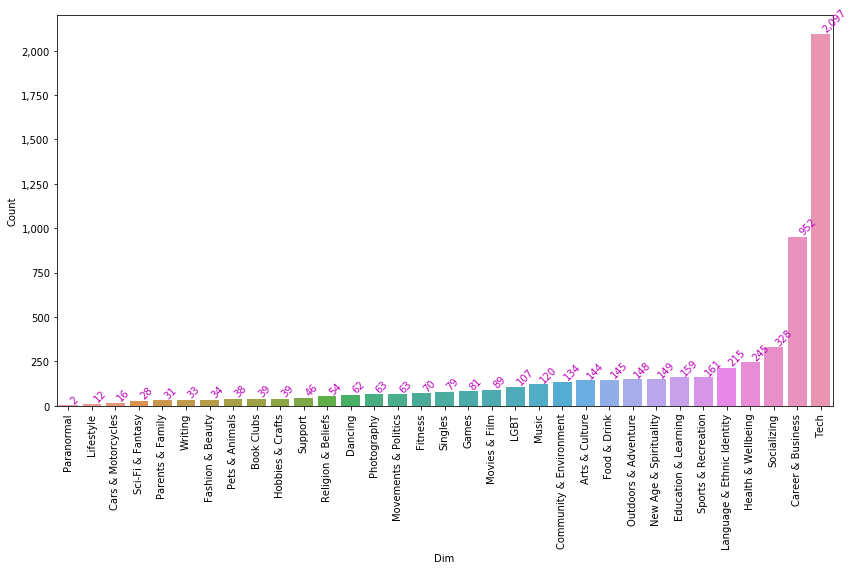

In [ ]:
cat_amounts = {}
cat_names = {}
cat_vals = []
cat_csv = pd.read_csv(datadir+'/categories.csv')
for index, row in cat_csv.iterrows():
    cat_names[str(row["category_id"])] = row["category_name"]
    
print(cat_names)


for h in hyperedges:
    if cat_names[str(hyperedges[h]["category"])] not in cat_vals:
        cat_vals.append(cat_names[str(hyperedges[h]["category"])])
    if cat_names[str(hyperedges[h]["category"])] not in cat_amounts:
        cat_amounts[cat_names[str(hyperedges[h]["category"])]]=1
    else:
        cat_amounts[cat_names[str(hyperedges[h]["category"])]]+=1

pd_df = pd.DataFrame(list(cat_amounts.items()))
pd_df.columns =["Dim","Count"]
# sort df by Count column
pd_df = pd_df.sort_values(['Count']).reset_index(drop=True)

plt.figure(figsize=(12,8))
# plot barh chart with index as x values
ax = sns.barplot(pd_df.index, pd_df.Count)
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Dim", ylabel='Count')
# add proper Dim values as x labels
ax.set_xticklabels(pd_df.Dim)
for item in ax.get_xticklabels(): item.set_rotation(90)
for i, v in enumerate(pd_df["Count"].iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='m', va ='bottom', rotation=45)
print(cat_vals)
plt.tight_layout()
plt.show()

In [ ]:
# cat_names = {}
# cat_csv = pd.read_csv(datadir+'/categories.csv')
# for index, row in cat_csv.iterrows():
#     cat_names[str(row["category_id"])] = row["category_name"]
# cat_vals = [cat_names[key] for key in cat_names]
# print(cat_vals)

In [ ]:
# for h_index in hyperedges:
#     hyperedge = hyperedges[h_index]
#     if hyperedge["category"]=="2" or hyperedge["category"]=="34":
#         hyperedge["category"] = "0"
#     else:
#         hyperedge["category"] = "1"

In [ ]:
from HypergraphRandomWalks import SubsampleAndTraverse

walksSAT = SubsampleAndTraverse(length=50, 
                                   num_walks=50, 
                                   hyperedges=hyperedges, 
                                   vertexMemberships=vertexMemberships,
                                   p_traverse_method="inverse",
                                   p_traverse=0.15, 
                                   p_traverse_initial=0.1)

In [ ]:
from HypergraphRandomWalks import TraverseAndSelect

walksTAS = TraverseAndSelect(length=50, 
                               num_walks=50, 
                               hyperedges=hyperedges, 
                               vertexMemberships=vertexMemberships,
                               p_select_method="inverse",
                               p_select=0.15, 
                               p_select_initial=0.1)

In [ ]:
with open(datadir+'/walksSAT.p', 'wb') as fp:
    pickle.dump(walksSAT, fp)

with open(datadir+'/walksTAS.p', 'wb') as fp:
    pickle.dump(walksTAS, fp)

In [ ]:
from Embeddings import EmbedWord2Vec

vertex_embedding_dimension = 16
hyperedge_embedding_dimension = 128

vertex_ids, vertex_embeddings = EmbedWord2Vec(walks=walksSAT,dimension=vertex_embedding_dimension)
print("Vertex embeddings finished.")
hyperedge_ids, hyperedge_embeddings = EmbedWord2Vec(walks=walksTAS,dimension=hyperedge_embedding_dimension)
print("Hyperedge embeddings finished.")

Creating embeddings.
Embedding generation runtime:  1056.7662060260773
Vertex embeddings finished.
Creating embeddings.


In [ ]:
print(len(vertex_embeddings))
with open(datadir+'/vertex_embeddings_'+str(max_groupsize)+'.p', 'wb') as fp:
    pickle.dump(vertex_embeddings, fp)
print(len(hyperedge_embeddings))
with open(datadir+'/hyperedge_embeddings_'+str(max_groupsize)+'.p', 'wb') as fp:
    pickle.dump(hyperedge_embeddings, fp)

In [ ]:
# with open(datadir+'/hyperedges.p', 'rb') as rb:
#      hyperedges = pickle.load(rb)
# with open(datadir+'/vertexMemberships.p', 'rb') as rb:
#     vertexMemberships = pickle.load(rb)
# with open(datadir+'/walks_hyperedge.p', 'rb') as rb:
#     walks_hyperedge = pickle.load(rb)
# with open(datadir+'/walk_labels_hyperedge.p', 'rb') as rb:
#     walk_labels_hyperedge = pickle.load(rb)
# with open(datadir+'/walks_node.p', 'rb') as rb:
#     walks_node = pickle.load(rb)
# with open (datadir+'/node_embeddings.p', 'rb') as rb:
#     node_embeddings = pickle.load(rb)


In [ ]:
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def visualizePCA(embeddings,obj,with_labels=None,ids=None):
    transform = PCA

    trans = transform(n_components=2)
    embeddings_2d = trans.fit_transform(embeddings)

    alpha = 0.7
    plt.figure(figsize=(7,7))
    plt.axes().set(aspect="equal")
    
    if with_labels:
        targets = [int(with_labels[identifier]['category'])-1 for identifier in ids]
        cmap = cm.rainbow(np.linspace(0.0, 1.0, num_categories))
        colors = cmap[targets]
        
        plt.scatter(embeddings_2d[:,0], 
                    embeddings_2d[:,1], 
                    cmap="jet", c=colors, alpha=alpha)
    else:
        plt.scatter(embeddings_2d[:,0], 
                    embeddings_2d[:,1], 
                    cmap="jet", alpha=alpha)
    
    plt.title('PCA visualization of '+obj+' embeddings in the hypergraph.'.format(transform.__name__))
    plt.show()
    
def visualizeTSNE(embeddings,obj,with_labels=None,ids=None):
    transform = TSNE

    trans = transform(n_components=2)
    embeddings_2d = trans.fit_transform(embeddings)

    alpha = 0.7
    plt.figure(figsize=(7,7))
    plt.axes().set(aspect="equal")
    
    if with_labels:
        targets = [int(with_labels[identifier]['category'])-1 for identifier in ids]
        cmap = cm.rainbow(np.linspace(0.0, 1.0, num_categories))
        colors = cmap[targets]
        
        plt.scatter(embeddings_2d[:,0], 
                    embeddings_2d[:,1], 
                    cmap="jet", c=colors, alpha=alpha)
    else:
        plt.scatter(embeddings_2d[:,0], 
                    embeddings_2d[:,1], 
                    cmap="jet", alpha=alpha)
    
    plt.title('TSNE visualization of '+obj+' embeddings in the hypergraph.'.format(transform.__name__))
    plt.show()
    
visualizePCA(vertex_embeddings,"vertex")
visualizeTSNE(hyperedge_embeddings,"hyperedge",hyperedges,hyperedge_ids)

In [22]:
def getTrainingData():
    i = 0
    lists = []
    labels = []
    maxi = 0
    for h in hyperedges:
        
        vertex_embedding_list = []
        hyperedge = hyperedges[h]
        for vertex in hyperedge["members"]:
            i+=1
            if i%100000==0:
                print(i)
            try: # Good ol' nondeterminism
                vertex_embedding_list.append(vertex_embeddings[vertex_ids.index(vertex)].tolist())
            except:
                print("Missed one: ",vertex)
        lists.append({"v":vertex_embedding_list,"h":hyperedge_embeddings[hyperedge_ids.index(h)].tolist()})
        label = np.zeros((num_categories,))
        label[int(hyperedge["category"])-1] = 1
        labels.append(label)
    X_unshuffled = []
    
    for hlist in lists:
        np_vertex_embeddings = np.asarray(hlist["v"])
        x = np.zeros((hyperedge_embedding_dimension + vertex_embedding_dimension*max_groupsize,))
        i = 0
        x[:hyperedge_embedding_dimension] = hlist["h"]
        
        for embedding in np_vertex_embeddings:
            x[hyperedge_embedding_dimension + i*embedding.shape[0]:hyperedge_embedding_dimension + (i+1)*embedding.shape[0]] = embedding
            i+=1
        X_unshuffled.append(x)
    labels = np.asarray(labels)
    X_arr, Y_arr = shuffle(X_unshuffled, labels)
    X = np.asarray(X_arr)
    Y = np.asarray(Y_arr)
    return X, Y

X, Y = getTrainingData()

print(X.shape)
print(Y.shape)

# np.save(datadir+'/X_hyperedge_'+str(max_groupsize)+'.npy', X)
# np.save(datadir+'/Y_hyperedge_'+str(max_groupsize)+'.npy', Y)

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.9, test_size=0.1)

100000
200000
300000
400000
(5983, 8128)
(5983, 33)


In [44]:
%load_ext autoreload
%autoreload 2

from Models import DeepHyperedges
from keras.callbacks import ModelCheckpoint, TensorBoard
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

dataset_name = "meetup"
batch_size = 128
num_epochs = 70

deephyperedges_model = DeepHyperedges(vertex_embedding_dimension=vertex_embedding_dimension,
                                     hyperedge_embedding_dimension=hyperedge_embedding_dimension,
                                     max_hyperedge_size=max_groupsize,
                                     num_outputs=num_categories,
                                     dataset_name=dataset_name)
plot_model(deephyperedges_model, to_file='images/'+dataset_name+'_deephyperedges_model.png')
checkpointer = ModelCheckpoint(filepath='weights/'+dataset_name+'/deephyperedges_weights.hdf5', verbose=0, save_best_only=True)
tbCallBack = TensorBoard(log_dir='logs/'+dataset_name+'/deephyperedges_logs_multi', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, update_freq='batch')

history = deephyperedges_model.fit(X_train, Y_train, epochs=num_epochs, batch_size=batch_size,
        shuffle=True, validation_split=0.1,
        callbacks=[checkpointer,tbCallBack], verbose=1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Train on 4845 samples, validate on 539 samples
Epoch 1/70
4845/4845 [==============================] - 26s 5ms/step - loss: 2.7698 - mean_absolute_error: 0.0511 - categorical_accuracy: 0.3007 - f1_m: 0.1605 - val_loss: 2.3792 - val_mean_absolute_error: 0.0467 - val_categorical_accuracy: 0.3618 - val_f1_m: 0.3501
Epoch 2/70
4845/4845 [==============================] - 6s 1ms/step - loss: 2.1817 - mean_absolute_error: 0.0440 - categorical_accuracy: 0.4072 - f1_m: 0.3981 - val_loss: 2.1621 - val_mean_absolute_error: 0.0438 - val_categorical_accuracy: 0.4212 - val_f1_m: 0.4009
Epoch 3/70
4845/4845 [==============================] - 6s 1ms/step - loss: 2.0023 - mean_absolute_error: 0.0411 - categorical_accuracy: 0.4574 - f1_m: 0.4452 - val_loss: 2.0353 - val_mean_absolute_error: 0.0416 - val_categorical_accuracy: 0.4545 - val_f1_m: 0.4323
Epoch 4/70
4845/4845 [==============================] - 8s 2ms/ste

Epoch 62/70
4845/4845 [==============================] - 11s 2ms/step - loss: 0.5712 - mean_absolute_error: 0.0177 - categorical_accuracy: 0.8398 - f1_m: 0.8277 - val_loss: 1.5689 - val_mean_absolute_error: 0.0293 - val_categorical_accuracy: 0.5788 - val_f1_m: 0.5751
Epoch 63/70
4845/4845 [==============================] - 10s 2ms/step - loss: 0.5792 - mean_absolute_error: 0.0181 - categorical_accuracy: 0.8380 - f1_m: 0.8240 - val_loss: 1.5796 - val_mean_absolute_error: 0.0294 - val_categorical_accuracy: 0.5714 - val_f1_m: 0.5920
Epoch 64/70
4845/4845 [==============================] - 10s 2ms/step - loss: 0.5993 - mean_absolute_error: 0.0187 - categorical_accuracy: 0.8312 - f1_m: 0.8180 - val_loss: 1.5561 - val_mean_absolute_error: 0.0287 - val_categorical_accuracy: 0.5918 - val_f1_m: 0.6020
Epoch 65/70
4845/4845 [==============================] - 10s 2ms/step - loss: 0.5593 - mean_absolute_error: 0.0175 - categorical_accuracy: 0.8469 - f1_m: 0.8355 - val_loss: 1.5823 - val_mean_absol

In [45]:
from sklearn.metrics import classification_report, accuracy_score

target_names = cat_vals
print(target_names)
y_pred = deephyperedges_model.predict(X_test, batch_size=16, verbose=1)
finals_pred = []
finals_test = []
for p in y_pred:
    m = 0
    ind = 0
    final = 0
    for i in p:
        if i>m:
            m=i
            final=ind
        ind+=1
    finals_pred.append(final)

for i in Y_test:
    ind=0
    for j in i:
        if j==1:
            finals_test.append(ind)
        ind+=1
           
print(classification_report(finals_test, finals_pred, target_names=target_names))
print(accuracy_score(finals_test, finals_pred))

['Tech', 'Career & Business', 'Socializing', 'Games', 'Community & Environment', 'Sci-Fi & Fantasy', 'Health & Wellbeing', 'Singles', 'Education & Learning', 'Photography', 'Book Clubs', 'Religion & Beliefs', 'Movies & Film', 'Hobbies & Crafts', 'LGBT', 'Pets & Animals', 'Writing', 'New Age & Spirituality', 'Dancing', 'Food & Drink', 'Sports & Recreation', 'Arts & Culture', 'Music', 'Language & Ethnic Identity', 'Movements & Politics', 'Fashion & Beauty', 'Parents & Family', 'Outdoors & Adventure', 'Cars & Motorcycles', 'Fitness', 'Support', 'Lifestyle', 'Paranormal']
599/599 [==============================] - 53s 89ms/step
[30, 11, 13, 6, 1, 31, 26, 6, 22, 15, 9, 30, 6, 6, 20, 6, 13, 8, 20, 3, 6, 6, 6, 22, 6, 6, 8, 26, 13, 1, 9, 3, 13, 0, 6, 1, 1, 6, 31, 6, 22, 1, 6, 11, 1, 25, 30, 6, 29, 30, 30, 1, 6, 5, 13, 21, 6, 22, 26, 1, 10, 21, 6, 3, 6, 1, 6, 1, 30, 15, 12, 6, 5, 4, 1, 13, 0, 26, 1, 1, 30, 1, 0, 11, 1, 9, 1, 6, 3, 6, 3, 6, 19, 24, 9, 1, 29, 6, 6, 12, 6, 3, 30, 6, 6, 6, 6, 30, 5

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [46]:
def getMLPTrainingData():
    i = 0
    lists = []
    labels = []
    maxi = 0
    for h in hyperedges:
        vertex_embedding_list = []
        hyperedge = hyperedges[h]
        lists.append({"h":hyperedge_embeddings[hyperedge_ids.index(h)].tolist()})
        label = np.zeros((num_categories,))
        label[int(hyperedge["category"])-1] = 1
        labels.append(label)
    X_unshuffled = []
    for hlist in lists:
        x = np.zeros((hyperedge_embedding_dimension,))
        x[:hyperedge_embedding_dimension] = hlist["h"]
        X_unshuffled.append(x)
    labels = np.asarray(labels)
    X_arr, Y_arr = shuffle(X_unshuffled, labels)
    X_MLP = np.asarray(X_arr)
    Y_MLP = np.asarray(Y_arr)
    return X_MLP, Y_MLP

X_MLP, Y_MLP = getMLPTrainingData()
# np.save(datadir+'/X_MLP_'+str(max_groupsize)+'.npy', X_MLP)
# np.save(datadir+'/Y_MLP_'+str(max_groupsize)+'.npy', Y_MLP)

from sklearn.model_selection import train_test_split
X_MLP_train, X_MLP_test, Y_MLP_train, Y_MLP_test = train_test_split(X_MLP, Y_MLP, train_size=0.9, test_size=0.1)

In [47]:
%autoreload 2
from Models import MLP
dataset_name = "meetup"
batch_size = 128
num_epochs = 50

MLP_model = MLP(input_dimension=hyperedge_embedding_dimension,
                 num_outputs=num_categories,
                 dataset_name=dataset_name)
plot_model(MLP_model, to_file='images/'+dataset_name+'_MLP_model.png')
checkpointer = ModelCheckpoint(filepath='weights/'+dataset_name+'/MLP_weights.hdf5', verbose=0, save_best_only=True)
tbCallBack = TensorBoard(log_dir='logs/'+dataset_name+'/MLP_logs_multi', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, update_freq='batch')

history = MLP_model.fit(X_MLP_train, Y_MLP_train, epochs=num_epochs, batch_size=batch_size,
        shuffle=True, validation_split=0.1,
        callbacks=[checkpointer,tbCallBack], verbose=1)

Train on 4845 samples, validate on 539 samples
Epoch 1/50
4845/4845 [==============================] - 6s 1ms/step - loss: 2.8413 - mean_absolute_error: 0.0526 - categorical_accuracy: 0.2918 - f1_m: 0.1156 - val_loss: 2.5075 - val_mean_absolute_error: 0.0486 - val_categorical_accuracy: 0.3748 - val_f1_m: 0.2165
Epoch 2/50
4845/4845 [==============================] - 1s 170us/step - loss: 2.2969 - mean_absolute_error: 0.0460 - categorical_accuracy: 0.3971 - f1_m: 0.3164 - val_loss: 2.2853 - val_mean_absolute_error: 0.0453 - val_categorical_accuracy: 0.4007 - val_f1_m: 0.3480
Epoch 3/50
4845/4845 [==============================] - 1s 169us/step - loss: 2.0957 - mean_absolute_error: 0.0429 - categorical_accuracy: 0.4438 - f1_m: 0.4018 - val_loss: 2.1589 - val_mean_absolute_error: 0.0429 - val_categorical_accuracy: 0.4230 - val_f1_m: 0.3954
Epoch 4/50
4845/4845 [==============================] - 1s 169us/step - loss: 1.9661 - mean_absolute_error: 0.0410 - categorical_accuracy: 0.4838 - f1_

In [49]:
Y_pred_MLP = MLP_model.predict(X_MLP_test, batch_size=16, verbose=1)
finals_pred_MLP = []
finals_test_MLP = []
for p in Y_pred_MLP:
    m = 0
    ind = 0
    final = 0
    for i in p:
        if i>m:
            m=i
            final=ind
        ind+=1
    finals_pred_MLP.append(final)

for i in Y_MLP_test:
    ind=0
    for j in i:
        if j==1:
            finals_test_MLP.append(ind)
        ind+=1
            
print(classification_report(finals_test_MLP, finals_pred_MLP, target_names=target_names[:-2]))
print(accuracy_score(finals_test_MLP, finals_pred_MLP))

599/599 [==============================] - 1s 1ms/step
                            precision    recall  f1-score   support

                      Tech       0.53      0.60      0.56        15
         Career & Business       0.63      0.61      0.62       105
               Socializing       0.00      0.00      0.00         4
                     Games       0.59      0.50      0.54        20
   Community & Environment       0.00      0.00      0.00         4
          Sci-Fi & Fantasy       0.00      0.00      0.00        13
        Health & Wellbeing       0.77      0.90      0.83       216
                   Singles       0.00      0.00      0.00         6
      Education & Learning       0.25      0.25      0.25         4
               Photography       0.58      0.70      0.64        10
                Book Clubs       0.62      0.62      0.62         8
        Religion & Beliefs       0.67      1.00      0.80        12
             Movies & Film       0.50      0.25      0.33   

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
def getTrainingData():
    i = 0
    lists = []
    labels = []
    maxi = 0
    for h in hyperedges:
        vertex_embedding_list = []
        hyperedge = hyperedges[h]
        for vertex in hyperedge["members"]:
            i+=1
            if i%100000==0:
                print(i)
            try: # Good ol' nondeterminism
                vertex_embedding_list.append(vertex_embeddings[vertex_ids.index(vertex)].tolist())
            except:
                print("Missed one: ",vertex)
        lists.append({"v":vertex_embedding_list})
        label = np.zeros((num_categories,))
        label[int(hyperedge["category"])-1] = 1
        labels.append(label)
    X_unshuffled = []
    
    for hlist in lists:
        np_vertex_embeddings = np.asarray(hlist["v"])
        x = np.zeros((vertex_embedding_dimension*max_groupsize,))
        i = 0        
        for embedding in np_vertex_embeddings:
            x[i*embedding.shape[0]:(i+1)*embedding.shape[0]] = embedding
            i+=1
        X_unshuffled.append(x)
    labels = np.asarray(labels)
    X_arr, Y_arr = shuffle(X_unshuffled, labels)
    X = np.asarray(X_arr)
    Y = np.asarray(Y_arr)
    return X, Y

X_deepset, Y_deepset = getTrainingData()

print(X_deepset.shape)
print(Y_deepset.shape)

# np.save(datadir+'/X_deepset_'+str(max_groupsize)+'.npy', X_deepset)
# np.save(datadir+'/Y_deepset_'+str(max_groupsize)+'.npy', Y_deepset)

from sklearn.model_selection import train_test_split
X_deepset_train, X_deepset_test, Y_deepset_train, Y_deepset_test = train_test_split(X_deepset, Y_deepset, train_size=0.9, test_size=0.1)

In [ ]:
%autoreload 2

from Models import DeepSets
from keras.callbacks import ModelCheckpoint, TensorBoard
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

dataset_name = "meetup"
batch_size = 128
num_epochs = 50

deepsets_model = DeepSets(vertex_embedding_dimension=vertex_embedding_dimension,
                             max_hyperedge_size=max_groupsize,
                             num_outputs=num_categories,
                             dataset_name=dataset_name)
plot_model(deepsets_model, to_file='images/'+dataset_name+'_deepsets_model.png')
checkpointer = ModelCheckpoint(filepath='weights/'+dataset_name+'/deepsets_weights.hdf5', verbose=0, save_best_only=True)
tbCallBack = TensorBoard(log_dir='logs/'+dataset_name+'/deepsets_logs_multi', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True, update_freq='batch')

history = deepsets_model.fit(X_deepset_train, Y_deepset_train, epochs=num_epochs, batch_size=batch_size,
        shuffle=True, validation_split=0.1,
        callbacks=[checkpointer,tbCallBack], verbose=1)

In [ ]:
Y_pred_deepsets = deepsets_model.predict(X_deepset_test, batch_size=16, verbose=1)
target_names = cat_vals
finals_pred_deepsets = []
finals_test_deepsets = []
for p in Y_pred_deepsets:
    m = 0
    ind = 0
    final = 0
    for i in p:
        if i>m:
            m=i
            final=ind
        ind+=1
    finals_pred_deepsets.append(final)

for i in Y_deepset_test:
    ind=0
    for j in i:
        if j==1:
            finals_test_deepsets.append(ind)
        ind+=1
            
print(classification_report(finals_test_deepsets, finals_pred_deepsets, target_names=target_names))
print(accuracy_score(finals_test_deepsets, finals_pred_deepsets))